In [24]:
#Global Value for number of tweets
num_tweets = 1000

#imports
import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import re
from textblob import TextBlob
import itertools
import os
import tweepy as tw
import pickle
from datetime import date
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

#load Naive Bayes classifier from pickle
f = open('my_classifier.pickle', 'rb')
classifier = pickle.load(f)
f.close()

#Twitter API
import config
consumer_key = config.consumer_key
consumer_secret = config.consumer_secret
access_token = config.access_token
access_token_secret = config.access_token_secret

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

#Defines functions to be used in program

#Cleans HTML Input from string
def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html) 
  return TextBlob(cleantext.lower())

# This is how the Naive Bayes classifier expects the input
# removes stopwords from string
# returns a dictionary
def create_word_features(words):
    useful_words = [word for word in words if word not in stopwords.words("english")]
    my_dict = dict([(word, True) for word in useful_words])
    return my_dict

#Process Input
def findusefulwords(arr, sentiment):
    unique_words = {}
    useful_words = []

    for x in range (arr[0].size):
       unique_words[x] = set(cleanhtml(arr[0][x]).split(' '))

    for x in range (len(unique_words)):
        useful_words.append((create_word_features(unique_words[x]), sentiment))
    return useful_words

def remove_url(txt):
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

#Search twitter API
def searchTwitter(search_string):
    search_string = search_string + "-filter:retweets"
    today = date.today()
    d1 = today.strftime("%d/%m/%Y")
    tweets = tw.Cursor(api.search,
                       q=search_string,
                       lang="en",
                       since='2018/01/01').items(num_tweets)
    all_tweets = [remove_url(tweet.text).lower() for tweet in tweets]
    searchTwitter.total_tweets = len(all_tweets)
    return all_tweets

#Classify Tweets
def classifyTweets(tweets):
    tokenizedTweets = []
    positive = 0
    negative = 0
    tweets = np.array(tweets)
    for x in range (len(tweets)):
        tokenizedTweet = (create_word_features(tweets[x]))
        if classifier.classify(tokenizedTweet) == 'positive':
          positive = positive+1
        elif classifier.classify(tokenizedTweet) == 'negative':
          negative = negative + 1
    print('Postive : ', positive)
    print('Negative : ', negative)
    if (negative > positive):
      return 'Negative'
    else:
      return "Positive"

def percentage(part,whole):
  return 100 * float(part)/float(whole)

def create_wordcloud(text):
  mask = np.array(Image.open('cloud.png'))
  stopwords = set(STOPWORDS)
  wc = WordCloud(background_color='white',
  mask = mask,
  max_words=3000,
  stopwords=stopwords,
  repeat=True)
  wc.generate(str(text))
  wc.to_file('wc.png')
  path='wc.png'
  display(Image.open(path))
  return

def sentimentIntensityAnalysis(search_string):
  x = searchTwitter(search_string)
  positive = 0
  negative = 0
  neutral = 0
  tweet_list = []
  neutral_list = []
  negative_list = []
  positive_list = []
  for tweet in x:
    tweet_list.append(tweet)
    analysis = TextBlob(tweet)
    sentiment = SentimentIntensityAnalyzer().polarity_scores(tweet)
    neg = sentiment['neg']
    neu = sentiment['neu']
    pos = sentiment['pos']
    if neg > pos:
      negative_list.append(tweet)
      negative += 1
    elif pos > neg:
      positive_list.append(tweet)
      positive += 1
    elif pos == neg:
      neutral_list.append(tweet)
      neutral += 1
  SentimentIntensityAnalyzer.positive = percentage(positive, searchTwitter.total_tweets)
  SentimentIntensityAnalyzer.negative = percentage(negative, searchTwitter.total_tweets)
  SentimentIntensityAnalyzer.neutral = percentage(neutral, searchTwitter.total_tweets)
  SentimentIntensityAnalyzer.tweet_list = pd.DataFrame(tweet_list)
  SentimentIntensityAnalyzer.tweet_list.drop_duplicates(inplace = True)
  SentimentIntensityAnalyzer.neutral_list = pd.DataFrame(neutral_list)
  SentimentIntensityAnalyzer.negative_list = pd.DataFrame(negative_list)
  SentimentIntensityAnalyzer.positive_list = pd.DataFrame(positive_list)
  return

def displayResults():
  num_pos = len(SentimentIntensityAnalyzer.positive_list)
  num_neg = len(SentimentIntensityAnalyzer.negative_list)
  num_neu = len(SentimentIntensityAnalyzer.neutral_list)
  positive = SentimentIntensityAnalyzer.positive
  neutral = SentimentIntensityAnalyzer.neutral
  negative = SentimentIntensityAnalyzer.negative
  print("% Tweets Postive : " ,positive, "% or ", num_pos, " / ", searchTwitter.total_tweets, " tweets")
  print("% Tweets Neutral : " ,neutral, "% or ", num_neu, " / ", searchTwitter.total_tweets, " tweets")
  print("% Tweets Negative : " ,negative, "% or ", num_neg, " / ", searchTwitter.total_tweets, " tweets")
  if (num_pos >= num_neu) and (num_pos >= num_neg):
    print("Overall Sentiment is Positive")
  elif (num_neu >= num_pos) and (num_neu >= num_neg):
    print("Overall sentiment is Neutral")
  elif (num_neg >= num_pos) and (num_neg >= num_neu):
    print("Overall sentiment is Negative")
  #Creating PieCart
  labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
  colors = ['green', 'blue','red']
  sizes = [positive, neutral, negative]
  patches, texts = plt.pie(sizes,colors=colors, startangle=90)
  plt.style.use('default')
  plt.legend(labels)
  plt.title('Twitter Sentiment Analysis Result for search : '+search_string+'' )
  plt.axis('equal')
  plt.show()  
  #max length of a tweet is 280 chars
  pd.options.display.max_colwidth = 280
  print("Postive")
  print(SentimentIntensityAnalyzer.positive_list.head(25))
  create_wordcloud(SentimentIntensityAnalyzer.positive_list.values)
  print("Neutral")
  print(SentimentIntensityAnalyzer.neutral_list.head(25))
  create_wordcloud(SentimentIntensityAnalyzer.neutral_list.values)
  print("Negative")
  print(SentimentIntensityAnalyzer.negative_list.head(25))
  create_wordcloud(SentimentIntensityAnalyzer.negative_list.values)
  return

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
#This cell creates the Naive Bayes Classifier Algorithm, 
#you do not need to run this cell since the classifier is saved into the pickle file
#Extremely biased towards negative and not sure why. Going to use SentimentIntensityAnalyzer for better results

#seperate data into pos and neg reviews, find the useful words for each and save to pos_words and neg_words

#Read in Datafile
df = pd.read_csv('IMDBDataset.csv',engine='python', encoding='utf-8', error_bad_lines=False).to_numpy()
size = int(df.size/2)
pos_reviews = []
neg_reviews = []

for x in range (size):
    if(df[x][1] == 'positive'):
        pos_reviews.append((df[x]))
    elif(df[x][1] == 'negative'):
        neg_reviews.append((df[x]))
pos_reviews = np.array(pos_reviews).T
pos_words = findusefulwords(pos_reviews,"positive")

neg_reviews = np.array(neg_reviews).T
neg_words = findusefulwords(neg_reviews,"negative")

#split data into training and testing datasets
train_set = neg_words[:20000] + pos_words[:20000]
test_set =  neg_words[20000:] + pos_words[20000:]

#Train the classifier and save it using pickle
#Classify and save to pickle
classifier = NaiveBayesClassifier.train(train_set)
accuracy = nltk.classify.util.accuracy(classifier, test_set)
print(accuracy * 100)
# classifier.show_most_informative_features()
f = open('my_classifier.pickle', 'wb')
pickle.dump(classifier, f)
f.close()

In [ ]:
#Sentiment Analysis Using the naive bayes classifier trained on movie data
search = input("Enter a string to search : ")
tweets = searchTwitter(search)
sentiment = classifyTweets(tweets)
print("Twitter Sentiment of " , search, " : ", sentiment)

Enter a string to search : usa
Postive :  10
Negative :  490
Twitter Sentiment of  usa  :  Negative


Enter a string to search : united states
% Tweets Postive :  68.3 % or  683  /  1000  tweets
% Tweets Neutral :  11.4 % or  114  /  1000  tweets
% Tweets Negative :  20.3 % or  203  /  1000  tweets
Overall Sentiment is Positive


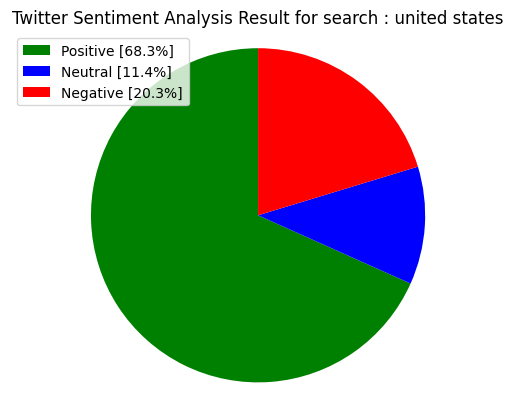

Postive
                                                                                                                    0
0                  patratdsp 0601 boosted1000 cp 678 lv 30lehi united states40412993111863333 pokemongo iv100 pgsharp
1                                   castform sunnydsp 0501 boosted1000 cp 318 lv 7san francisco united states37799613
2                  dianalunadiosa children protecting the interests of the united states corporation x profit company
3                   redtiggerlips children protecting the interests of the united states corporation x profit company
4                 nelliep42110184 children protecting the interests of the united states corporation x profit company
5       wendypr42941811 sandyskipper1 chappyricky blitzkriegbauer wokeanimal children protecting the interests of the
6     reggievaitz niasmom shabazzstuart the vaccines that we are using in the united states generate an antibody leve
7                  reddragonlady1 children prote

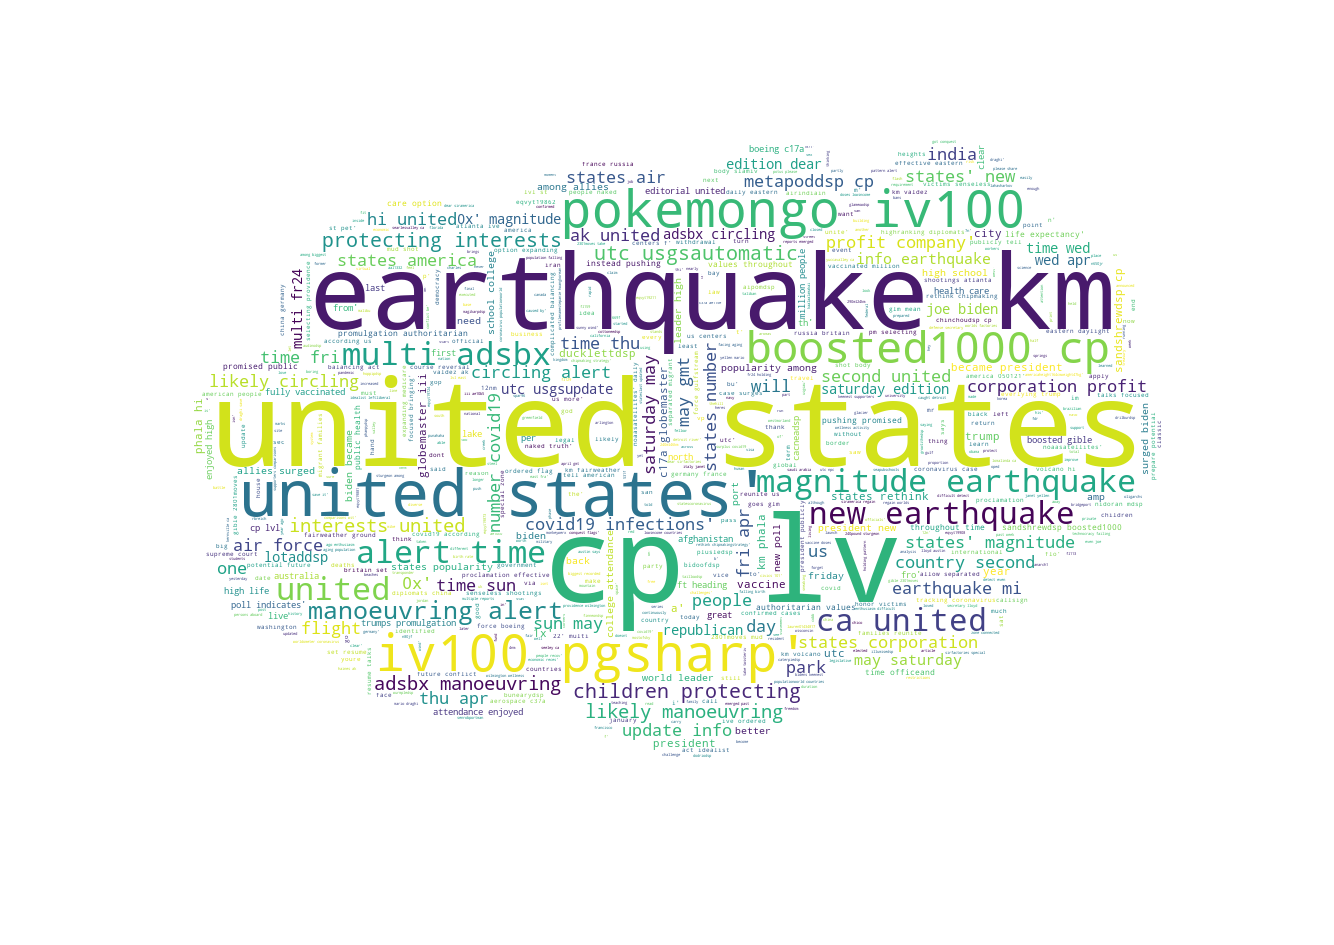

Neutral
                                                                                                                   0
0                       black man enslaved by white restaurant manager should be awarded more than 500000 court says
1                                                                          bmkibler this isnt 100 accurate but close
2                                                                    dnc raises 154 million in bidens first 100 days
3                             florida gov ron desantis to sign bill banning social media deplatforming via nypost do
4               if texas does pass permitless carry it will become the most populous state to do so but not the last
5       nytimes nbc washingtonpostall issued retractions for false claims about mayor giulianicontinuously and purpo
6          0111 pm 45 of them on 05032021 when selecting providence clinic at buena park community center jampj 18 5
7           0111 pm 45 of them on 05102021 when selectin

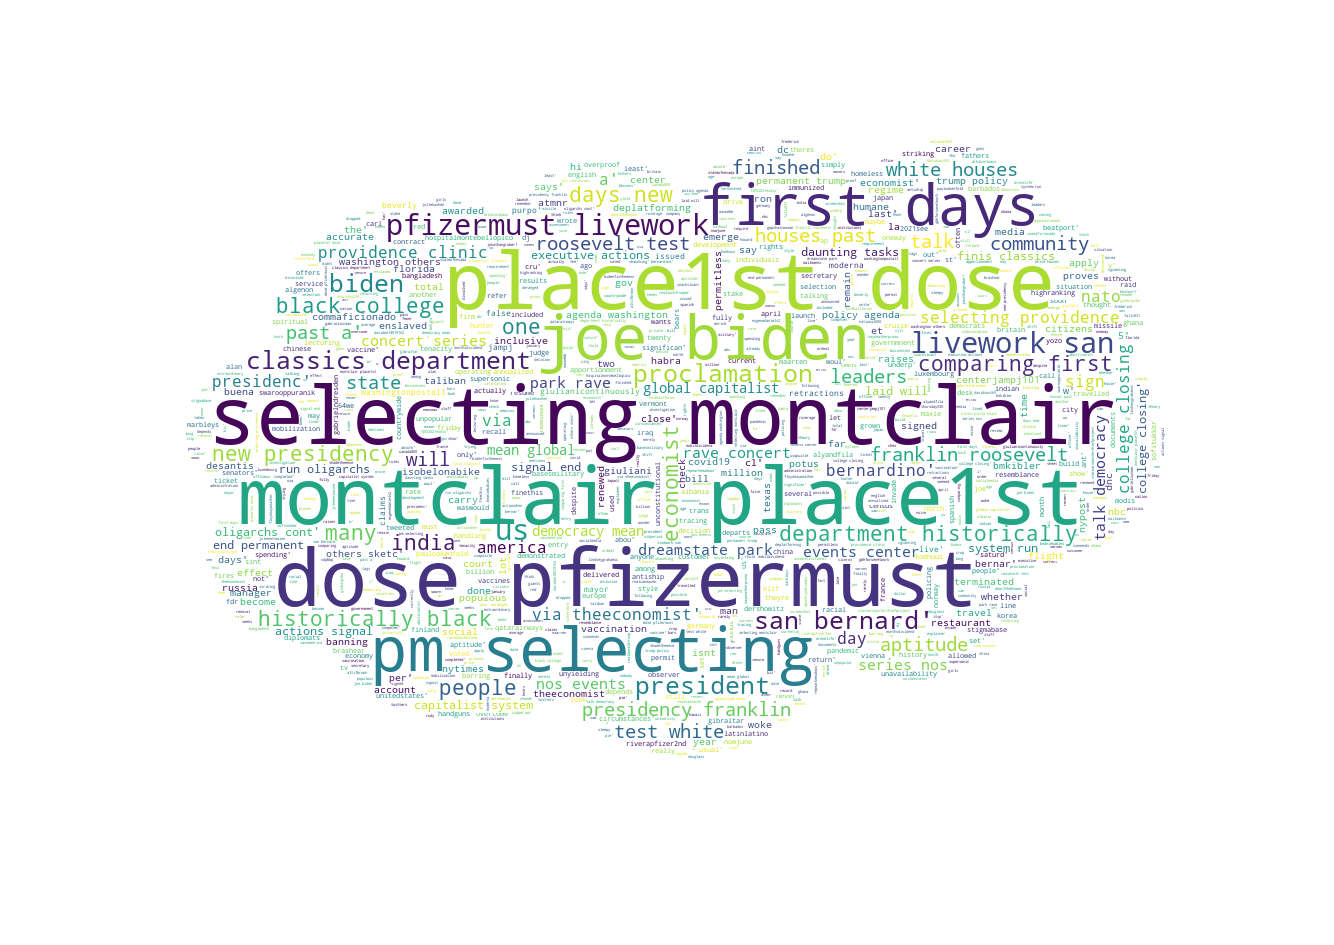

Negative
                                                                                                                     0
0          the united states has less than five percent of the worlds population but about 25 percent of the prisoners
1                                                            there is no greater threat to the united states than this
2        zippythechicken uh no that doesnt make sense aside from that there were people on my twitter timeline screami
3            in statement analysis that is a troubling statementive never represented a ukrainian national or official
4                                     california officials say capsized boat was smuggling vessel for migrants into us
5         for three decades us presidentstrump includedcontinually expanded wars forward deployments and defense commi
6     north korea has warned the united states will face a very grave situation because president joe biden made a big
7                                biden 

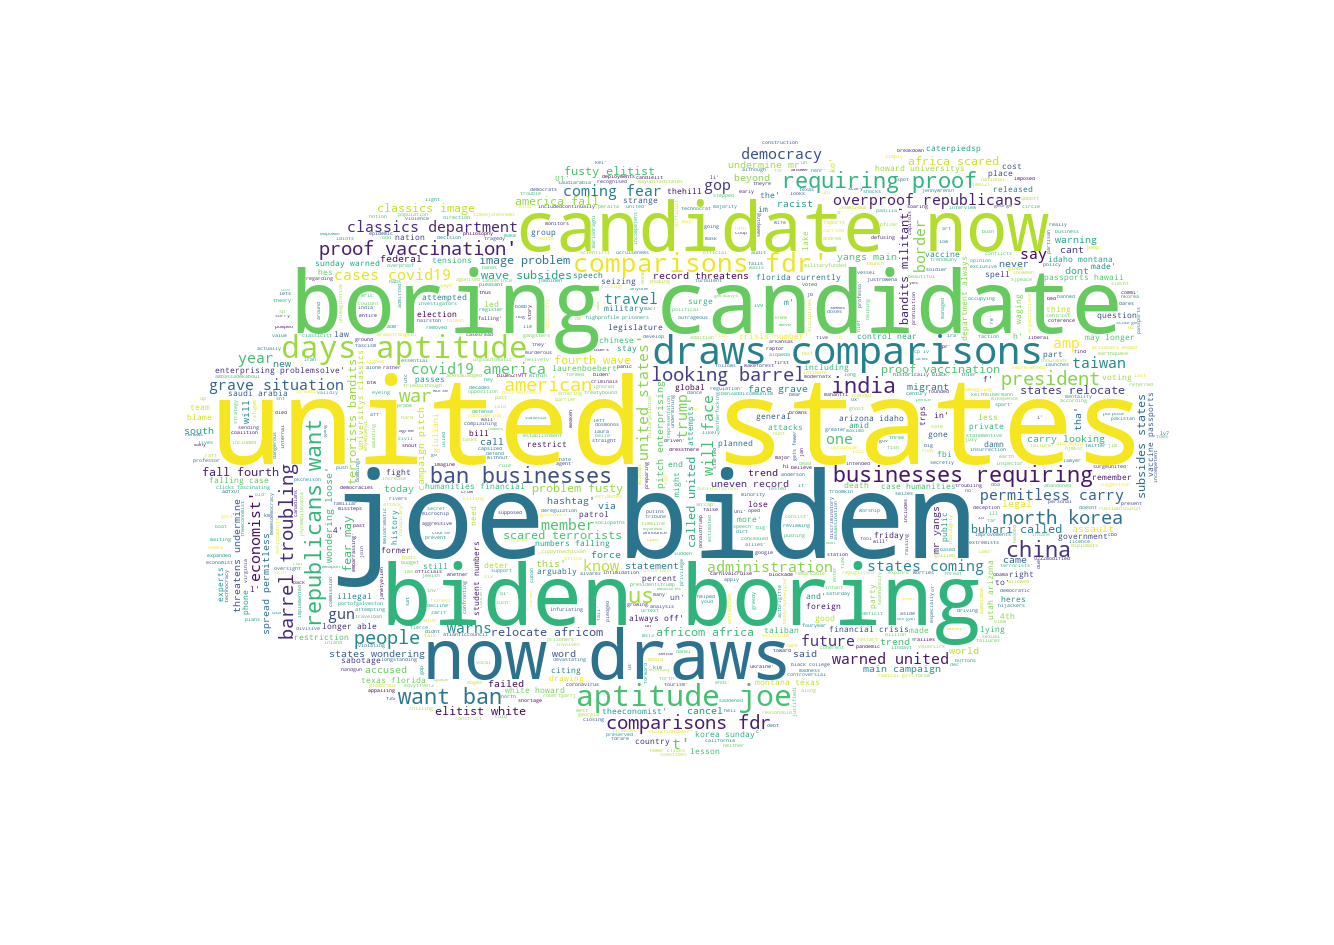

In [25]:
search_string = input("Enter a string to search : ")
sentimentIntensityAnalysis(search_string)
displayResults()